In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('./data/')
sys.path.append('./models/')
from thmodel import *
import pickle
with open('./data/dict_data_final.pkl', 'rb') as f:
    data = pickle.load(f)

# Datos $(x, y)$

In [2]:
x, y = data['Beneixama']

# Parámetros

In [3]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]

In [4]:
P = list_P[1]

# Resultados

In [5]:
grid = Grid(x=x, y=y, mode='gumbel')
grid.initialize(part=P)
grid.compute_th_param(grad=True)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

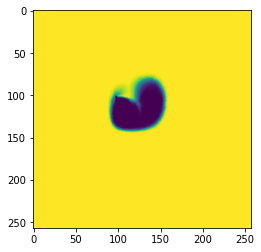

In [6]:
plt.imshow(grid.X0[:,:, -1].detach().numpy())

# Resultados para la tabla del paper

In [18]:
def CreateTable(x, y, list_P, list_alpha, list_beta, list_gamma, mode='bernoulli'):
    
    from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef

    columns = ['FP rate', 'FN rate', 'Accuracy', 'F1-score', 'MCC', 'Mean C', 'Median C']
    size_rows = len(list_alpha) * len(list_beta) * len(list_gamma) * len(list_P)
    size_cols = len(columns) 
    df = pd.DataFrame(np.zeros((size_rows, size_cols)), columns=columns)

    ind = 0

    for p in list_P:
        for a in list_alpha:
            for b in list_beta:
                for c in list_gamma:

                    print('Iteración:   ', ind)
                    
                    grid = Grid(x=x, y=y, mode=mode)
                    grid.initialize(part=p)
                    grid.compute_th_param(alpha=a, beta=b, gamma=c)
                    grid.submatrix()
                    grid.enlargement_process()
                    grid.montecarlo(n_it=100)

                    X = (grid.X[:, :, -1].numpy() != 0)*1
                    Y = (y[:, :, -1] != 0)*1

                    cmat = confusion_matrix(Y.flatten(), X.flatten(), normalize='true')

                    df.iloc[ind] = [
                        cmat[0,1],
                        cmat[1,0],
                        accuracy_score(Y.flatten(), X.flatten()),
                        f1_score(Y.flatten(), X.flatten()),
                        matthews_corrcoef(Y.flatten(), X.flatten()),
                        grid.div.mean().item(),
                        grid.div.median().item()
                    ]

                    ind += 1
    
    df['Sum metrics'] = df['Accuracy'] + df['F1-score'] + df['MCC']

    return df

## Tablas sobre los parámetros

In [19]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]

list_alpha = [0.8, 1., 1.2]
list_beta = [0.8, 1., 1.2]
list_gamma = [0.8, 1., 1.2]

In [20]:
df_metrics = CreateTable(x, y, list_P, list_alpha, list_beta, list_gamma)

Iteración:    0
Iteración:    1
Iteración:    2
Iteración:    3
Iteración:    4
Iteración:    5
Iteración:    6
Iteración:    7
Iteración:    8
Iteración:    9
Iteración:    10
Iteración:    11
Iteración:    12
Iteración:    13
Iteración:    14
Iteración:    15
Iteración:    16
Iteración:    17
Iteración:    18
Iteración:    19
Iteración:    20
Iteración:    21
Iteración:    22
Iteración:    23
Iteración:    24
Iteración:    25
Iteración:    26
Iteración:    27
Iteración:    28
Iteración:    29
Iteración:    30
Iteración:    31
Iteración:    32
Iteración:    33
Iteración:    34
Iteración:    35
Iteración:    36
Iteración:    37
Iteración:    38
Iteración:    39
Iteración:    40
Iteración:    41
Iteración:    42
Iteración:    43
Iteración:    44
Iteración:    45
Iteración:    46
Iteración:    47
Iteración:    48
Iteración:    49
Iteración:    50
Iteración:    51
Iteración:    52
Iteración:    53
Iteración:    54
Iteración:    55
Iteración:    56
Iteración:    57
Iteración:    58
Iteraci

In [61]:
df_metrics.to_csv('thmodel_metrics.csv')

# Creamos el dataframe de los parámetros para los join

In [26]:
columns = ['Part', 'Alpha', 'Beta', 'Gamma']
size_rows = len(list_alpha) * len(list_beta) * len(list_gamma) * len(list_P)
size_cols = len(columns) 

In [27]:
df_param = pd.DataFrame(np.zeros((size_rows, size_cols)), columns=columns)

########
ind = 0
########
i = 0
for p in list_P:
    j = 0
    for a in list_alpha:
        k = 0
        for b in list_beta:
            l = 0
            for c in list_gamma:
                df_param.iloc[ind] = [i, j, k, l]
                l += 1
                ind += 1
            k += 1
        j += 1
    i += 1


In [48]:
ind = np.argsort(df_metrics['Sum metrics'].values)[::-1]

for m in ind:
    i, j, k, l = df_param.iloc[m].values
    i, j, k, l = int(i), int(j), int(k), int(l)
    print(m, 'Partition:   ', list_P[i], 'Alpha:   ', list_alpha[j], 'Beta:    ', list_beta[k], 'Gamma:    ', list_gamma[l])

20 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.2 Beta:     0.8 Gamma:     1.2
19 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.2 Beta:     0.8 Gamma:     1.0
21 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.2 Beta:     1.0 Gamma:     0.8
23 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.2 Beta:     1.0 Gamma:     1.2
22 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.2 Beta:     1.0 Gamma:     1.0
10 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.0 Beta:     0.8 Gamma:     1.0
11 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.0 Beta:     0.8 Gamma:     1.2
9 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.0 Beta:     0.8 Gamma:     0.8
18 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.2 Beta:     0.8 Gamma:     0.8
0 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    0.8 Beta:     0.8 Gamma:     0.8
24 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    1.2 Beta:     1.2 Gamma:     0.8
1 Partition:    [0, 0.1, 0.5, 0.9, 1.01] Alpha:    0.8 Beta:     0.

# Figuras

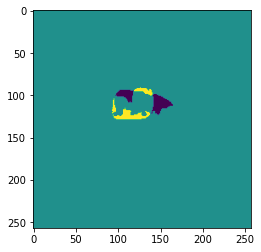

In [55]:
p = list_P[0]
a = list_alpha[-1]
b = list_beta[0]
c = list_gamma[-1]

grid = Grid(x=x, y=y)
grid.initialize(part=p)
grid.compute_th_param(alpha=a, beta=b, gamma=c)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

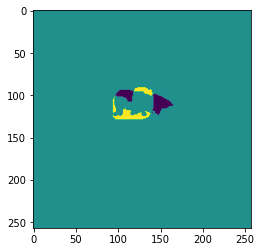

In [56]:
p = list_P[0]
a = list_alpha[-1]
b = list_beta[0]
c = list_gamma[1]

grid = Grid(x=x, y=y)
grid.initialize(part=p)
grid.compute_th_param(alpha=a, beta=b, gamma=c)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

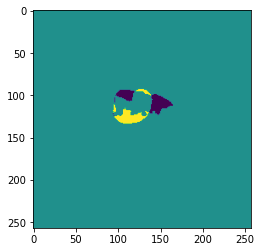

In [57]:
p = list_P[1]
a = list_alpha[0]
b = list_beta[1]
c = list_gamma[1]

grid = Grid(x=x, y=y)
grid.initialize(part=p)
grid.compute_th_param(alpha=a, beta=b, gamma=c)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)